Raw Data Loaded Successfully.
Ticker           TSLA                                                     SPY  \
Price            Open       High        Low      Close     Volume        Open   
Date                                                                            
2015-07-01  18.073999  18.174667  17.856667  17.943333   31518000  175.111010   
2015-07-02  18.680000  18.830000  18.220667  18.667999  107458500  175.397596   
2015-07-06  18.591999  18.779333  18.420000  18.648001   61828500  173.458790   
2015-07-07  18.333332  18.346666  17.384666  17.858667   91576500  174.461903   
2015-07-08  17.288000  17.386667  16.954000  16.997334   93316500  174.006719   

Ticker                                                           BND  \
Price             High         Low       Close     Volume       Open   
Date                                                                   
2015-07-01  175.363905  174.124732  174.917130  135979900  60.794171   
2015-07-02  175.566188  174.33544

C:\Users\eep\AppData\Local\Temp\ipykernel_34892\1477431626.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


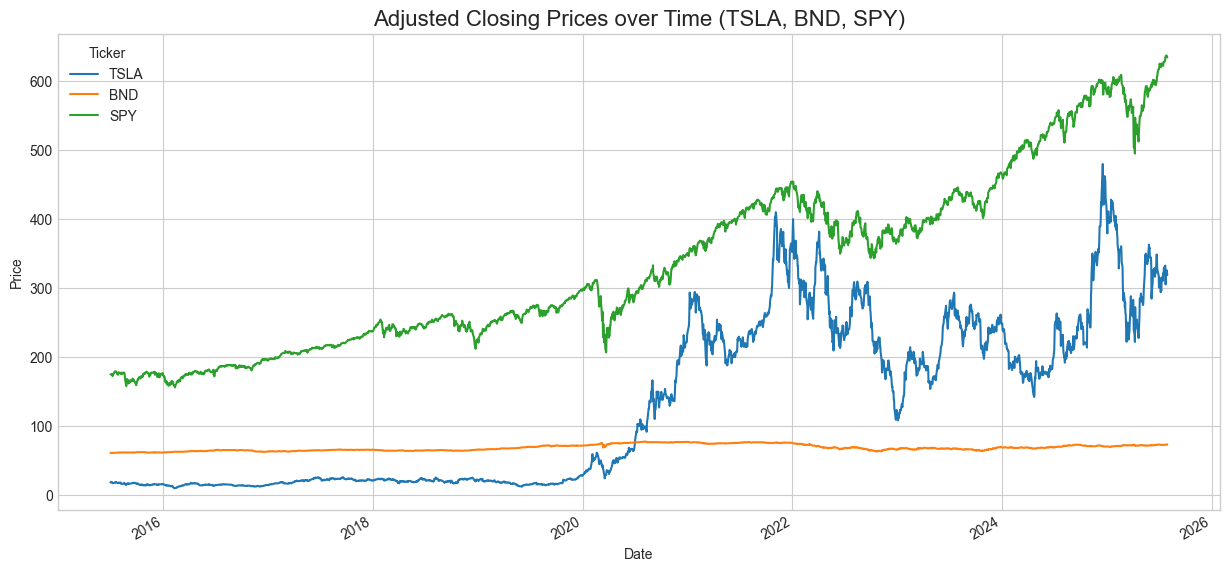

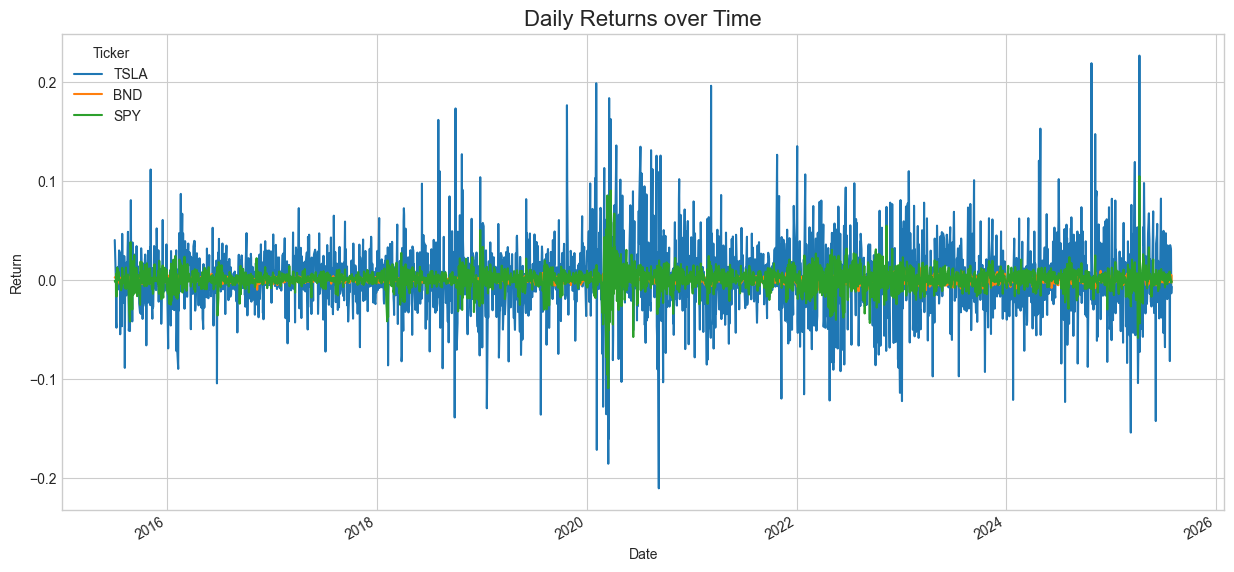

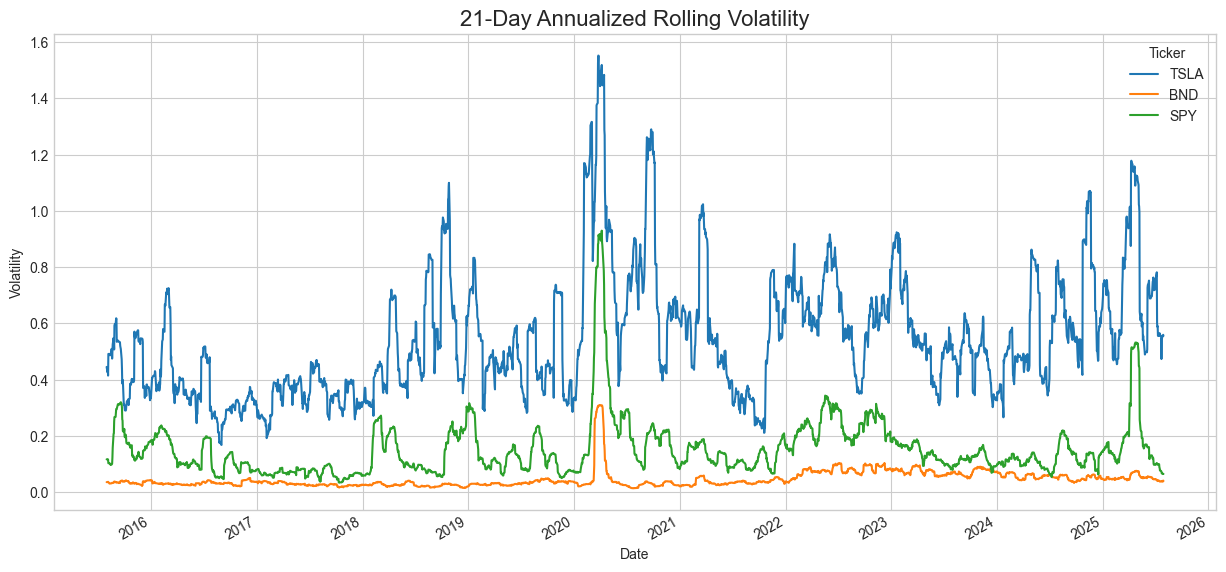


TSLA Outliers (Daily Returns > 3 standard deviations from mean):
Date
2025-04-09    0.226900
2024-10-24    0.219190
2020-02-03    0.198949
2021-03-09    0.196412
2020-03-19    0.183877
2019-10-24    0.176692
2018-10-01    0.173471
2020-03-24    0.162817
2018-08-02    0.161880
2024-04-29    0.153069
2024-11-06    0.147510
2020-02-04    0.137256
2020-04-13    0.136038
2022-01-03    0.135317
2020-07-06    0.134794
2020-08-12    0.131236
2018-10-23    0.127189
2021-10-25    0.126616
2020-09-14    0.125832
2020-08-31    0.125689
2024-04-24    0.120611
2025-03-24    0.119336
2020-03-02    0.113220
2020-08-17    0.112031
2022-12-27   -0.114089
2022-01-27   -0.115542
2020-03-12   -0.116172
2021-11-09   -0.119903
2024-01-25   -0.121253
2022-04-26   -0.121841
2023-01-03   -0.122422
2024-07-24   -0.123346
2020-02-27   -0.128146
2019-01-18   -0.129711
2020-03-09   -0.135725
2019-07-25   -0.136137
2018-09-28   -0.139015
2025-06-05   -0.142599
2025-03-10   -0.154262
2020-03-18   -0.160344
2020-02-0

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm

# Set a consistent style for plots
plt.style.use('seaborn-v0_8-whitegrid')

# --- Load Data ---
# The path is relative to the notebook's location.
file_path = '../data/raw/financial_data.csv'
try:
    # The header=[0, 1] argument is correct for the multi-level header
    # created by yfinance.download with group_by='ticker'.
    data = pd.read_csv(file_path, header=[0, 1], index_col=0, parse_dates=True)
    data.index.name = 'Date'
    print("Raw Data Loaded Successfully.")
    print(data.head())
    print(data.info())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please run the 'scripts/data_ingestion.py' script first to fetch the data.")
    # Exit the cell or notebook gracefully
    # In a notebook, you can simply stop execution here.
    raise

# --- Data Cleaning and Preprocessing ---
# Handle missing values by forward-filling them.
# The 'Date' index is already handled during the read_csv step.
data.fillna(method='ffill', inplace=True)
print("\nMissing values after ffill:")
print(data.isnull().sum().sum())
# The FutureWarning is noted but the method is still effective.

# Extract only the Adjusted Close prices and rename columns for simplicity.
# This approach is more robust as it directly accesses the MultiIndex.
clean_data = pd.DataFrame()
for ticker in ['TSLA', 'BND', 'SPY']:
    # yfinance often provides a multi-level index like ('TSLA', 'Adj Close').
    # This code safely accesses that level.
    try:
        clean_data[ticker] = data[ticker]['Adj Close']
    except KeyError:
        # Fallback to 'Close' if 'Adj Close' is not available, which is rare but good practice.
        print(f"Warning: 'Adj Close' not found for {ticker}. Using 'Close' instead.")
        clean_data[ticker] = data[ticker]['Close']

print("\nCleaned and Prepared Data:")
print(clean_data.head())

# --- Feature Engineering ---
# Calculate daily percentage returns.
returns = clean_data.pct_change().dropna()
print("\nDaily Returns:")
print(returns.head())

# Calculate annualized rolling volatility (21 trading days in a month).
rolling_vol = returns.rolling(window=21).std() * np.sqrt(252)
print("\nAnnualized Rolling Volatility:")
print(rolling_vol.head())

# Save preprocessed data for subsequent tasks
# This is a good practice to avoid re-running the preprocessing steps.
# Create the processed directory if it doesn't exist
import os
if not os.path.exists('../data/processed'):
    os.makedirs('../data/processed')
clean_data.to_csv('../data/processed/clean_prices.csv')
returns.to_csv('../data/processed/returns.csv')
rolling_vol.to_csv('../data/processed/rolling_volatility.csv')


# --- Exploratory Data Analysis (EDA) ---

# Visualize closing prices
plt.figure(figsize=(15, 7))
clean_data.plot(ax=plt.gca())
plt.title('Adjusted Closing Prices over Time (TSLA, BND, SPY)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(title='Ticker')
plt.show()

# Visualize daily returns
plt.figure(figsize=(15, 7))
returns.plot(ax=plt.gca())
plt.title('Daily Returns over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend(title='Ticker')
plt.show()

# Visualize rolling volatility
plt.figure(figsize=(15, 7))
rolling_vol.plot(ax=plt.gca())
plt.title('21-Day Annualized Rolling Volatility', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend(title='Ticker')
plt.show()

# Outlier Detection
tsla_returns = returns['TSLA']
# A common rule of thumb is to look for returns more than 3 standard deviations away from the mean.
outliers = tsla_returns[(np.abs(tsla_returns) > tsla_returns.std() * 3)]
print(f"\nTSLA Outliers (Daily Returns > 3 standard deviations from mean):\n{outliers.sort_values(ascending=False)}")


# --- Seasonality and Trends (Augmented Dickey-Fuller Test) ---
def adf_test(series, title=''):
    """
    Performs the Augmented Dickey-Fuller test to check for stationarity.
    A p-value <= 0.05 indicates the series is likely stationary.
    """
    print(f'--- ADF Test for {title} ---')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '#Lags Used', 'Number of Observations']
    for value, label in zip(result, labels):
        print(f'{label}: {value:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    if result[1] <= 0.05:
        print(f"Result: The series is likely stationary (p-value = {result[1]:.4f}).")
    else:
        print(f"Result: The series is likely non-stationary (p-value = {result[1]:.4f}).")

# Test on TSLA Closing Price
adf_test(clean_data['TSLA'], title='TSLA Closing Price')

# Test on TSLA Daily Returns (which should be stationary)
adf_test(returns['TSLA'], title='TSLA Daily Returns')

# Discussion on ADF Test:
# The test on 'TSLA Closing Price' should show a high p-value (> 0.05), indicating it's non-stationary.
# This means the series has a trend or seasonality and its statistical properties change over time.
# The test on 'TSLA Daily Returns' should show a very low p-value (<= 0.05), indicating it's stationary.
# This is why models like ARIMA, which require stationarity, typically work on returns or differenced prices.

# --- Foundational Risk Metrics ---
# Annualize returns and volatility for all assets
annual_returns = returns.mean() * 252
annual_volatility = returns.std() * np.sqrt(252)

# Value at Risk (VaR)
# VaR at 95% confidence level.
# This measures the maximum potential loss over a specified time period at a given confidence level.
confidence_level = 0.05
tsla_var_95 = -np.percentile(returns['TSLA'], confidence_level * 100)
print(f"\nHistorical VaR (95%) for TSLA: {tsla_var_95:.4f}")

# Sharpe Ratio
# Measures risk-adjusted return. Assumes a 2% annual risk-free rate.
risk_free_rate = 0.02
sharpe_ratio = (annual_returns - risk_free_rate) / annual_volatility
print("\nAnnualized Sharpe Ratios:")
print(sharpe_ratio)